In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, einops]"
!pip install -q pytorch-lightning~=2.0
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

import os
import shutil
import tempfile
import matplotlib.pyplot as plt

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    SpatialPadd,
    RandFlipd,
    RandCropByPosNegLabeld,
    CenterSpatialCropd,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    list_data_collate,
)
import torch
import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print_config()

directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
`torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
2025-12-04 14:43:34.958235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-04 14:43:34.958267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-04 14:43:34.959189: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-04 14:43:34.964474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow

`torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
2025-12-04 14:44:39.410545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-04 14:44:39.410581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-04 14:44:39.411498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-04 14:44:39.417046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, 

MONAI version: 1.6.dev2548
Numpy version: 1.26.2
Pytorch version: 2.9.1+cu128
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cca0c6d09175a7cf8250cf527092b671af05e303
MONAI __file__: /home/global/Anaconda3-2023.09/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.5
Nibabel version: 5.1.0
scikit-image version: 0.24.0
scipy version: 1.16.3
Pillow version: 12.0.0
Tensorboard version: 2.20.0
gdown version: 5.2.0
TorchVision version: 0.24.1+cu128
tqdm version: 4.66.2
lmdb version: 1.4.1
psutil version: 5.9.8
pandas version: 2.1.4
einops version: 0.8.1
transformers version: 4.32.1
mlflow version: 3.6.0
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://monai.readthedocs.io/en/latest/installation.html#installing-the-recommended-dependencies

/tmp/tmpd2r38lcq


In [4]:
# global configuration
BATCH_SIZE = 1
IMG_SIZE = (128, 128, 128)
PIX_DIM = (0.6, 0.6, 0.6)

class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()

        self._model = UNETR(
            in_channels=1,
            out_channels=28,
            img_size=IMG_SIZE,
            feature_size=16,
            hidden_size=768,
            mlp_dim=3072,
            num_heads=12,
            proj_type="perceptron",
            norm_name="instance",
            res_block=True,
            conv_block=True,
            dropout_rate=0.0,
        ).to(device)

        self.loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
        self.post_pred = AsDiscrete(argmax=True, to_onehot=28)
        self.post_label = AsDiscrete(to_onehot=28)
        self.dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
        self.best_val_dice = 0
        self.best_val_epoch = 0
        self.max_epochs = 1300
        self.check_val = 30
        self.warmup_epochs = 20
        self.metric_values = []
        self.epoch_loss_values = []
        self.validation_step_outputs = []
        # store config in instance if needed elsewhere
        self.batch_size = BATCH_SIZE
        self.img_size = IMG_SIZE
        self.pix_dim = PIX_DIM

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # prepare data
        data_dir = "/home/romain/SVN/python/romain/dataset/dataset0/"
        split_json = "dataset_2.json"
        datasets = data_dir + split_json
        datalist = load_decathlon_datalist(datasets, True, "training")
        val_files = load_decathlon_datalist(datasets, True, "validation")

        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=0,
                    a_max=400,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(keys=["image", "label"], pixdim=PIX_DIM, mode=("bilinear", "nearest"),),
                SpatialPadd(keys=["image","label"], spatial_size=IMG_SIZE, mode='constant'),
                CenterSpatialCropd(keys=["image", "label"], roi_size=IMG_SIZE),
                # RandCropByPosNegLabeld(
                #     keys=["image", "label"],
                #     label_key="label",
                #     spatial_size=IMG_SIZE,
                #     pos=1,
                #     neg=1,
                #     num_samples=4,
                #     image_key="image",
                #     image_threshold=0,
                # ),
                RandFlipd(
                    keys=["image", "label"],
                    spatial_axis=[0],
                    prob=0.10,
                ),
                RandFlipd(
                    keys=["image", "label"],
                    spatial_axis=[1],
                    prob=0.10,
                ),
                RandFlipd(
                    keys=["image", "label"],
                    spatial_axis=[2],
                    prob=0.10,
                ),
                RandRotate90d(
                    keys=["image", "label"],
                    prob=0.10,
                    max_k=3,
                ),
                RandShiftIntensityd(
                    keys=["image"],
                    offsets=0.10,
                    prob=0.50,
                ),
            ]
        )
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=0,
                    a_max=200,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(keys=["image", "label"], pixdim=PIX_DIM, mode=("bilinear", "nearest"),),
            ]
        )

        self.train_ds = CacheDataset(
            data=datalist,
            transform=train_transforms,
            cache_num=8,
            cache_rate=1.0,
            num_workers=0,
        )
        self.val_ds = CacheDataset(
            data=val_files,
            transform=val_transforms,
            cache_num=2,
            cache_rate=1.0,
            num_workers=0,
        )

    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True,
            collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=0, pin_memory=True)
        return val_loader

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self._model.parameters(), lr=1e-4, weight_decay=1e-5)
        return optimizer

    def training_step(self, batch, batch_idx):
        images = batch["image"].to(self.device)
        labels = batch["label"].to(self.device)
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        # store detached loss for aggregation at epoch end (Lightning v2 compatible)
        try:
            self._train_epoch_outputs.append(loss.detach().cpu())
        except Exception:
            # fallback in case attribute missing
            self._train_epoch_outputs = [loss.detach().cpu()]
        return {"loss": loss, "log": tensorboard_logs}

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self._train_epoch_outputs).mean()
        self.epoch_loss_values.append(avg_loss.detach().cpu().numpy())

#    def training_epoch_end(self, outputs):
#        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
#        self.epoch_loss_values.append(avg_loss.detach().cpu().numpy())

    def validation_step(self, batch, batch_idx):
        images = batch["image"].to(self.device)
        labels = batch["label"].to(self.device)
        roi_size = IMG_SIZE
        sw_batch_size = max(1, images.size(0))  # safe fallback
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        d = {"val_loss": loss, "val_number": len(outputs)}
        self.validation_step_outputs.append(d)
        return d

    def on_validation_epoch_end(self):
        val_loss, num_items = 0, 0
        for output in self.validation_step_outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        self.metric_values.append(mean_val_dice)
        self.validation_step_outputs.clear()  # free memory
        return {"log": tensorboard_logs}
        
        # initialise the LightningModule
net = Net()

# set up checkpoints
checkpoint_callback = ModelCheckpoint(dirpath=root_dir, filename="best_metric_model")

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    devices=[0],
    max_epochs=net.max_epochs,
    precision=16,  # active mixed precision
    check_val_every_n_epoch=net.check_val,
    callbacks=checkpoint_callback,
    default_root_dir=root_dir,
)

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [5]:
# train
trainer.fit(net)

monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
Loading dataset:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.90s/it]
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /tmp/tmpd2r38lcq exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | _model        | UNETR      | 121 M  | train
1 | loss_function | DiceCELoss | 0      | train
-----------------------------------------------------
121 M     Trainable params
0         Non-trainable params
121 M     Total params
485.403   Total estimated model params size (MB)
453       Mo

Sanity Checking: |                                                                                           |…

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /p

current epoch: 0 current mean dice: 0.0001
best mean dice: 0.0001 at epoch: 0


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                  |…

Validation: |                                                                                                |…

current epoch: 29 current mean dice: 0.0001
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 59 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 89 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 119 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 149 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 179 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 209 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 239 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 269 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 299 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 329 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 359 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 389 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 419 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 449 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 479 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 509 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 539 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 569 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 599 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 629 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 659 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 689 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 719 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 749 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 779 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29


Validation: |                                                                                                |…

current epoch: 809 current mean dice: 0.0000
best mean dice: 0.0001 at epoch: 29



Detected KeyboardInterrupt, attempting graceful shutdown ...


AssertionError: 

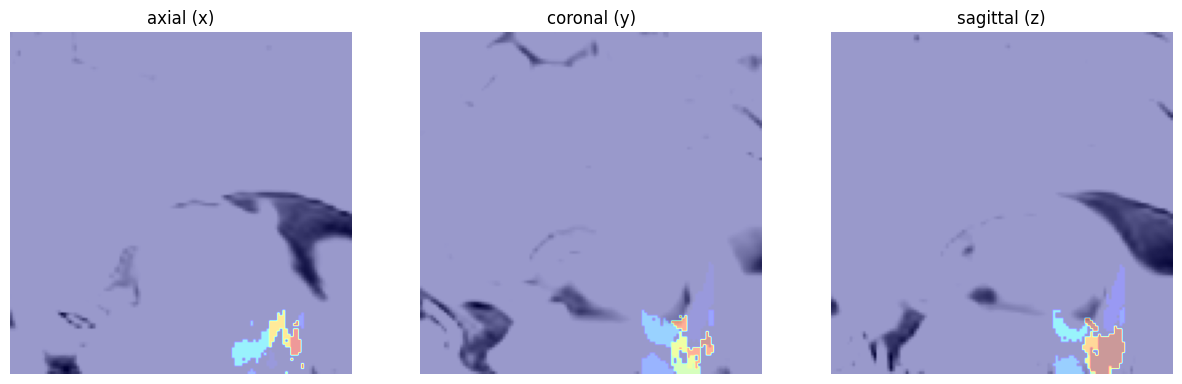

transformed image shape: torch.Size([128, 128, 128]) label shape: torch.Size([128, 128, 128])


In [6]:
# ...existing code...
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged,
    CropForegroundd, Orientationd, Spacingd, SpatialPadd, CenterSpatialCropd
)
from monai.data import load_decathlon_datalist
import numpy as np

# ajuster si nécessaire (mêmes valeurs que dans la cellule prepare_data)
DATA_DIR = "/home/romain/SVN/python/romain/dataset/dataset0/"
SPLIT_JSON = "dataset_2.json"
DATASETS = DATA_DIR + SPLIT_JSON

# charge la liste (ne lit pas encore les images)
datalist = load_decathlon_datalist(DATASETS, True, "training")
idx = 0  # index du cas à visualiser

# même pipeline de transforms que prepare_data
t = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=100, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(0.5, 0.5, 0.5), mode=("bilinear", "nearest")),
    SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 128), mode='constant'),
    CenterSpatialCropd(keys=["image", "label"], roi_size=(128, 128, 128)),
])

sample = datalist[idx].copy()  # dict avec chemins
out = t(sample)                # applique les transforms et charge les fichiers

img = out["image"]  # numpy, channel first (C,H,W,D) ou (C,Z,Y,X)
lbl = out["label"]

# si channel first, extraire la première composante
if img.ndim == 4:
    img = img[0]
if lbl.ndim == 4:
    lbl = lbl[0]

# choisir slices centraux et afficher 3 plans (axial, coronal, sagittal)
sx, sy, sz = img.shape
cx, cy, cz = sx // 2, sy // 2, sz // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axial (slice suivant l'axe 0)
axes[0].imshow(np.rot90(img[cx-5, :, :]), cmap="gray")
axes[0].imshow(np.rot90(lbl[cx-5, :, :]), cmap="jet", alpha=0.4)
axes[0].set_title("axial (x)")
# coronal (axe 1)
axes[1].imshow(np.rot90(img[cx, :, :]), cmap="gray")
axes[1].imshow(np.rot90(lbl[cx, :, :]), cmap="jet", alpha=0.4)
axes[1].set_title("coronal (y)")
# sagittal (axe 2)
axes[2].imshow(np.rot90(img[cx+5, :, :]), cmap="gray")
axes[2].imshow(np.rot90(lbl[cx+5, :, :]), cmap="jet", alpha=0.4)
axes[2].set_title("sagittal (z)")

for ax in axes:
    ax.axis("off")
plt.show()

print("transformed image shape:", img.shape, "label shape:", lbl.shape)
# ...existing code...

In [ ]:
# Remove model from memory
del net
torch.cuda.empty_cache()
net.collect()

NameError: name 'net' is not defined

### Plot the loss and metric

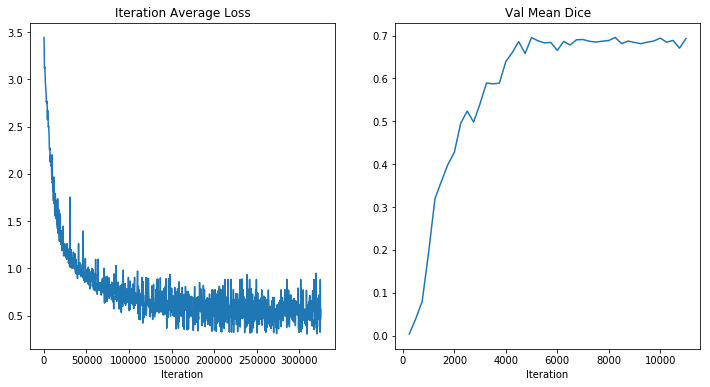

In [ ]:
eval_num = 250
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(net.epoch_loss_values))]
y = net.epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(net.metric_values))]
y = net.metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

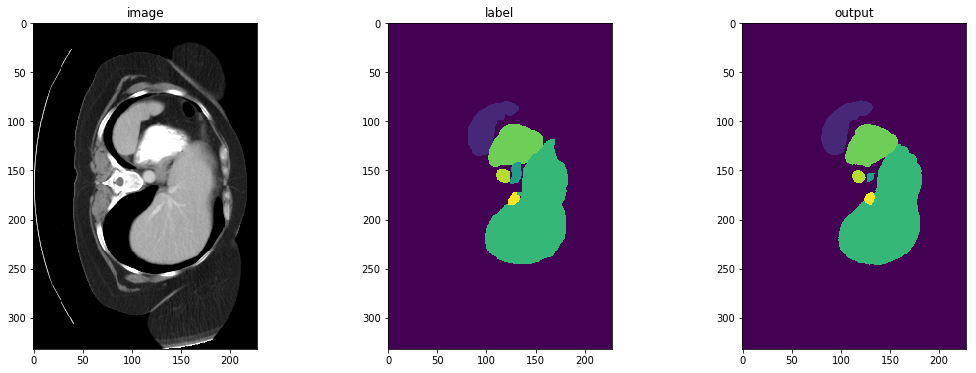

In [ ]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 4
net.load_from_checkpoint(os.path.join(root_dir, "best_metric_model-v1.ckpt"))
net.eval()
net.to(device)

with torch.no_grad():
    img_name = os.path.split(net.val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = net.val_ds[case_num]["image"]
    label = net.val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (186,186,186), 4, net, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
#if directory is None:
#    shutil.rmtree(root_dir)